## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

For network analysis homework, I want to look at the connections between different characters (or person names) in a book, which is Jane Austen's Emma. 

In [1]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

In [2]:
#First load text data to a single file chapter by chapter, and clean those irrelevant signals
emma_df = pandas.DataFrame(columns=["chapter", "text"])

with open("../week-5/austen-emma.txt", encoding="utf8", errors='ignore') as f:
    index = 0
    content = []
    for line in f:
        if "CHAPTER" in line:
            if len(content) == 0:
                continue
            else:
                link_c = "".join(content)
                link_c = link_c.replace("\n"," ").replace("\'s", "'s")
                emma_df = emma_df.append({"chapter": index, "text": link_c}, ignore_index=True)
                content = []
                index = index+1
        else:
            content.append(line)


In [3]:
emma_df

,chapter,text
0,0,[Emma by Jane Austen 1816] VOLUME I
1,1,"Emma Woodhouse, handsome, clever, and rich, ..."
2,2,"Mr. Weston was a native of Highbury, and bor..."
3,3,Mr. Woodhouse was fond of society in his own...
4,4,Harriet Smith's intimacy at Hartfield was so...
5,5,"""I do not know what your opinion may be, Mrs..."
6,6,Emma could not feel a doubt of having given ...
7,7,The very day of Mr. Elton's going to London ...
8,8,Harriet slept at Hartfield that night. For ...
9,9,"Mr. Knightley might quarrel with her, but Em..."


In [4]:
import sklearn.feature_extraction
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

#Now normalize the texts
emmaVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
emmaVects_incidence = emmaVectorizer.fit_transform(emma_df['text'])

In [5]:
#Now begin to create network by word occurance
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((emmaVectorizer.get_feature_names()[i] for i in range(emmaVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(emmaVects_incidence.shape[0]), bipartite = 'chapter')

#add all the edges
g_2mode.add_edges_from(((d, emmaVectorizer.get_feature_names()[w], {'weight' : emmaVects_incidence[d, w]}) for d, w in zip(*emmaVects_incidence.nonzero())))

In [6]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [7]:
#Now we draw the graph for chapters
gChap = contractNetwork(g_2mode, 'chapter')
print(nx.info(gChap))

Name: 
Type: Graph
Number of nodes: 55
Number of edges: 1485
Average degree:  54.0000


/Users/heatherchen/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


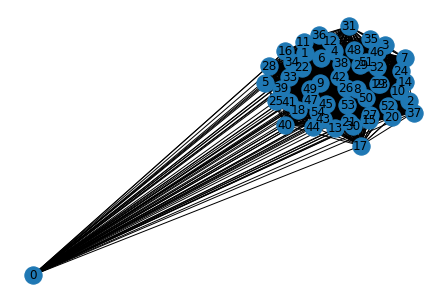

In [8]:
layout = nx.spring_layout(gChap, k = 1/3, weight='weight', iterations= 50)
nx.draw(gChap, pos = layout, labels = {n:n for n in gChap.nodes()}) #Getting labels is a bit annoying

This graph is very interesting in that we can see chapter 0 is linked loosely to every other chapter. The reason behind that is obvious, we can see from the original text dataframe that chapter 0 contains only the title of this book and its publish time. Next we remove this node. 

In [9]:
#Now we remove the first node
gChap.remove_node(0)

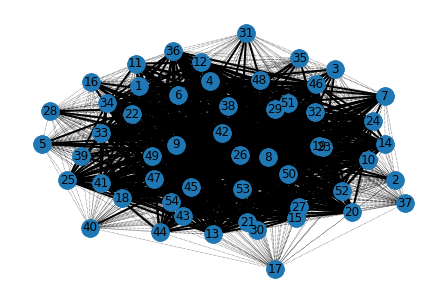

In [10]:
wMedian = np.median([d['weight'] for n1, n2, d in gChap.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gChap.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gChap.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gChap, pos = layout, labels = {n:n for n in gChap.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gChap, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see that only chapter 23, 50, 43, and 26 are in the centre of this book, while chapter 37, 17, 40 seem to have loose connection between other chapters in this book. 

Now I try to investigate in one of the center chapters (which is chapter 26), and look at what kind of words occurs most often in this chapter. 

In [11]:
print(len(emma_df.iloc[26]['text']),"words:","\n",emma_df.iloc[26]['text'].strip().replace('  ', '\n'))

35862 words: 
 Frank Churchill came back again; and if he kept his father's dinner waiting, it was not known at Hartfield; for Mrs. Weston was too anxious for his being a favourite with Mr. Woodhouse, to betray any imperfection which could be concealed.
He came back, had had his hair cut, and laughed at himself with a very good grace, but without seeming really at all ashamed of what he had done.
He had no reason to wish his hair longer, to conceal any confusion of face; no reason to wish the money unspent, to improve his spirits.
He was quite as undaunted and as lively as ever; and, after seeing him, Emma thus moralised to herself:--
"I do not know whether it ought to be so, but certainly silly things do cease to be silly if they are done by sensible people in an impudent way.
Wickedness is always wickedness, but folly is not always folly.--It depends upon the character of those who handle it. Mr. Knightley, he is _not_ a trifling, silly young man.
If he were, he would have done this 

Now let us look at the network of the whole book by word frequency.

In [12]:
#First normalize the texts
emma_df['tokenized_sents'] = emma_df['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
emma_df['normalized_sents'] = emma_df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [14]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [15]:
g_emma = wordCooccurrence(emma_df['normalized_sents'].sum())

In [16]:
len(g_emma)

6910

In [17]:
#Seems alright. Then we remove those edges whose weight is low and those isolated nodes
g_emma.remove_edges_from([(n1, n2) for n1, n2, d in g_emma.edges(data = True) if d['weight'] <= 25])
g_emma.remove_nodes_from(list(nx.isolates(g_emma)))

In [18]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [19]:
giant_emma = max(connected_component_subgraphs(g_emma), key=len) # keep just the giant connected component
print(nx.info(giant_emma))

Name: 
Type: Graph
Number of nodes: 97
Number of edges: 318
Average degree:   6.5567


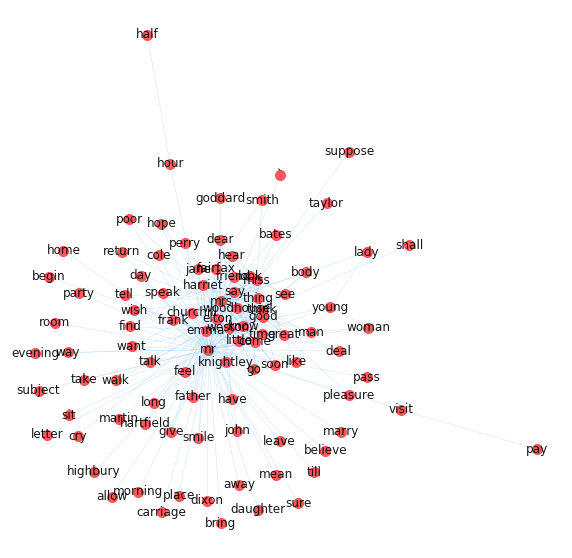

In [20]:
#Now let's begin to visualize this graph
layout = nx.spring_layout(giant_emma, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant_emma, ax = ax, pos = layout, labels = {n:n for n in giant_emma.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

The graph looks really promising! As we can see, the names of main characters are in the center of this graph, such as "harriet", "churchill", "weston", and "knightly". Also, those words around them are really "jane austen style", for example, we can see words like "party", "marriage" and "smile" surrounding those main characters. These words exactly show the theme of most Jane Austen novels.

In [21]:
#Now let's find what kind of words are completely connected to each other in this book
print(', '.join(max(nx.clique.find_cliques(giant_emma), key = lambda x: len(x))))

mr, emma, mrs, miss, think, weston, say, know, good, thing


In [22]:
#Now lets look at words that are directly related to our main character, emma
emmaNeighbors = giant_emma.neighbors('emma')
gnei_emma = giant_emma.subgraph(emmaNeighbors)
print(nx.info(gnei_emma))

Name: 
Type: Graph
Number of nodes: 47
Number of edges: 246
Average degree:  10.4681


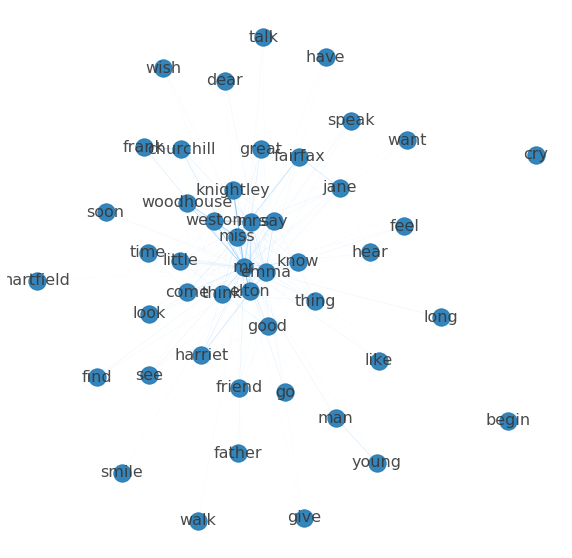

In [23]:
#Plot it. 
layout_emma = nx.spring_layout(gnei_emma, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in gnei_emma.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gnei_emma.edges(data = True)))
nx.draw(gnei_emma, ax = ax, pos = layout_emma, labels = {n:n for n in gnei_emma.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gnei_emma.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [25]:
#If we look at words within 2 steps of emma
gWord_emma = contractNetwork(g_2mode, 'word')
emmaNeighbors = gWord_emma.neighbors('emma')
emmaNeighborsPlus1 = set(emmaNeighbors)
for n in emmaNeighbors:
    emmaNeighborsPlus1 |= set(giant_emma.neighbors(n))

In [27]:
gnei_emma2 = giant_emma.subgraph(emmaNeighborsPlus1)
print(nx.info(gnei_emma2))

Name: 
Type: Graph
Number of nodes: 96
Number of edges: 271
Average degree:   5.6458


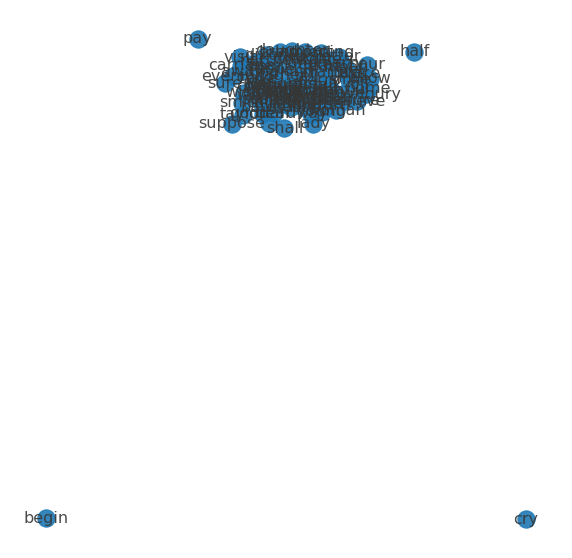

In [28]:
layout_emma = nx.spring_layout(gnei_emma2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_emma = nx.eigenvector_centrality(gnei_emma2)
maxC = max(centralities_emma.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gnei_emma2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gnei_emma2.edges(data = True)))
nx.draw(gnei_emma2, ax = ax, pos = layout_emma, labels = {n:n for n in gnei_emma2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gnei_emma2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

By looking at the first graph above, we can know which characters are more tightly connected to our main character emma. By looking at the second graph, beside those words that are in the center, one of the words that are isolated is "cry", which actually corresponds to Emma's personality. 

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

First look at centrality in the book "Emma".

In [29]:
dcentralities = nx.degree_centrality(giant_emma)

In [30]:
dcentralities['emma']

0.5

In [32]:
max(dcentralities.items(), key = lambda x : x[1])

('mr', 0.8854166666666666)

Wow... Our main character in fact does not have the highest centrality value. It is the prefix "Mr" that has the highest centrality value. It seems that this book is more about men than emma herself...

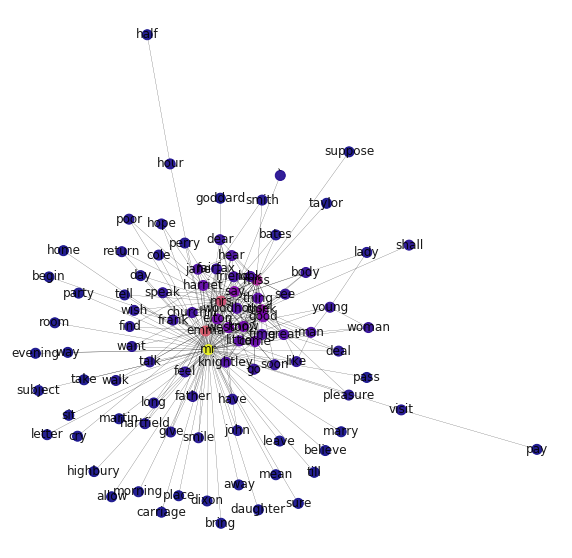

In [33]:
#Plot it using centrality
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant_emma, ax = ax, pos = layout, labels = {n:n for n in giant_emma.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant_emma.nodes],
        cmap = plt.get_cmap('plasma')) 

Besides "mr" and "mrs", only "emma" has relatively high centrality value. 

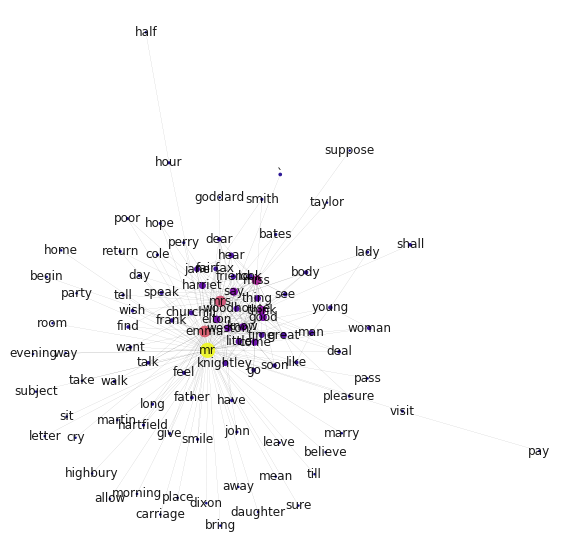

In [35]:
#Using another way to visualize this graph
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_emma.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_emma.edges(data = True)))
nx.draw(giant_emma, ax = ax, pos = layout, labels = {n:n for n in giant_emma.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord_emma.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant_emma.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant_emma.nodes],
        cmap = plt.get_cmap('plasma')) 

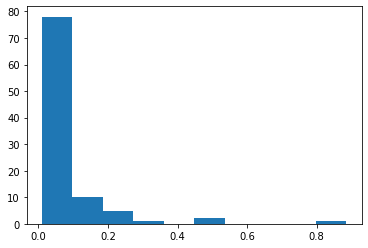

In [36]:
#Using histogram to plot degree centrality
plt.hist(list(dcentralities.values()))
plt.show()

Pretty exponential distribution just as expected

In [37]:
#Now let's look at the top 10 words in degrees
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('mr', 0.8854166666666666),
 ('emma', 0.5),
 ('mrs', 0.46875),
 ('miss', 0.3333333333333333),
 ('think', 0.26041666666666663),
 ('say', 0.22916666666666666),
 ('good', 0.19791666666666666),
 ('know', 0.1875),
 ('elton', 0.1875),
 ('weston', 0.17708333333333331)]

In [38]:
#And the last 10 words
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('believe', 0.010416666666666666),
 ('cry', 0.010416666666666666),
 ('martin', 0.010416666666666666),
 ('taylor', 0.010416666666666666),
 ('sit', 0.010416666666666666),
 ('carriage', 0.010416666666666666),
 ('goddard', 0.010416666666666666),
 ('highbury', 0.010416666666666666),
 ('marry', 0.010416666666666666),
 ('home', 0.010416666666666666)]

Among the top 10 words, beside those names of characters and prefix, there are a few verbs such as "think", "say", and "know". The reason why these verbs appear in the top list may be that they are all frequently used verbs even at 18th century. Also, in my opinion, these words also refect Jane Austen's writing style, which emphasizes a lot on leading roles' personal feelings. And the plot was often carried out by dialogues, that's why "say" appears in this list. 

Among the last 10 words, it is surprising to find out the that "marry" and "home" are among them. 

Next, let us look at betweenness centrality. 

In [40]:
centralities = nx.betweenness.betweenness_centrality(giant_emma)

In [41]:
centralities['emma']

0.11373821232373871

In [42]:
max(centralities.items(), key = lambda x : x[1])

('mr', 0.7037515268600799)

Nothing about the ranking of centraily has changed so far. 

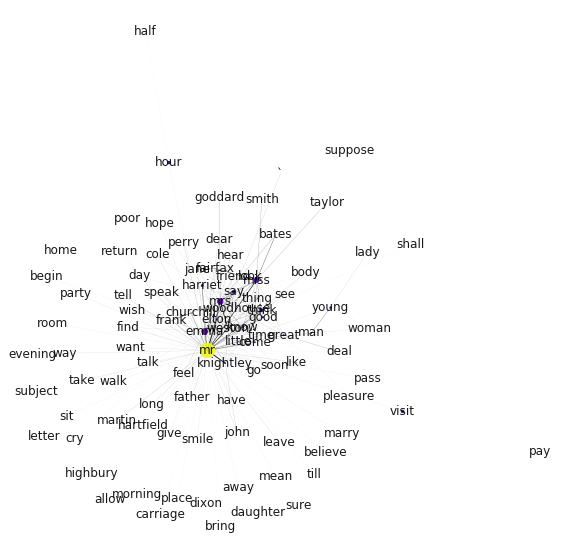

In [43]:
#Plot betweenness centrality
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_emma.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_emma.edges(data = True)))
nx.draw(giant_emma, ax = ax, pos = layout, labels = {n:n for n in giant_emma.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_emma.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant_emma.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant_emma.nodes],
        cmap = plt.get_cmap('plasma')) 

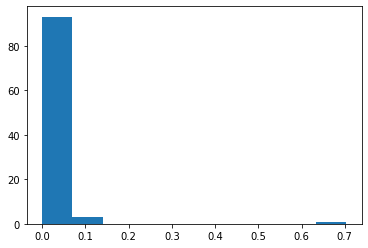

In [44]:
#Plot the distribution of betweenness centrality
plt.hist(list(centralities.values()))
plt.show()

In [46]:
#The top 10 words of betweenness centrality
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('mr', 0.7037515268600799),
 ('emma', 0.11373821232373871),
 ('mrs', 0.10241133926989192),
 ('miss', 0.07407514999620263),
 ('say', 0.027219366281866258),
 ('think', 0.026871297562087032),
 ('hour', 0.020833333333333332),
 ('visit', 0.020833333333333332),
 ('harriet', 0.011737329434697857),
 ('young', 0.005645031138452191)]

In [50]:
#The last 10 words of betweenness centrality
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[20:30]

[('thing', 0.00028641679957469427),
 ('little', 0.00026003297384876334),
 ('time', 0.00020338883825725927),
 ('friend', 0.00019354731525784158),
 ('lady', 0.00019005847953216374),
 ('like', 0.00018031189083820662),
 ('jane', 0.00015350877192982457),
 ('churchill', 0.00013157894736842105),
 ('smith', 8.528265107212476e-05),
 ('hear', 3.654970760233918e-05)]

The prefix "mr" still scores high in betweenness centrality score, which agrees to my former argument that this book is more about men and their society than women. 

Next, let us look at closeness centrality

In [51]:
centralities = nx.closeness_centrality(giant_emma)

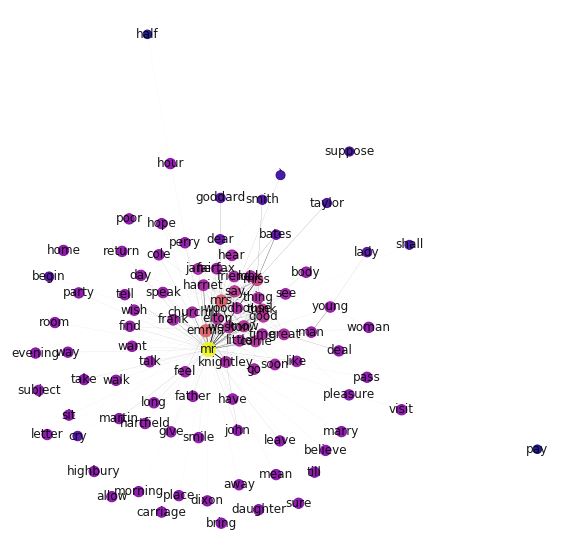

In [53]:
#Plot using closeness centrality
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_emma.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_emma.edges(data = True)))
nx.draw(giant_emma, ax = ax, pos = layout, labels = {n:n for n in giant_emma.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_emma.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant_emma.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant_emma.nodes],
        cmap = plt.get_cmap('plasma')) 

In [54]:
#Top 10 words
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('mr', 0.8807339449541285),
 ('emma', 0.6486486486486487),
 ('mrs', 0.6357615894039735),
 ('miss', 0.5853658536585366),
 ('think', 0.5614035087719298),
 ('say', 0.5581395348837209),
 ('good', 0.5423728813559322),
 ('know', 0.5393258426966292),
 ('elton', 0.5393258426966292),
 ('weston', 0.5363128491620112)]

In [55]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('begin', 0.3950617283950617),
 ('cry', 0.3950617283950617),
 ('goddard', 0.3902439024390244),
 ('smith', 0.3794466403162055),
 ('suppose', 0.37065637065637064),
 ('taylor', 0.37065637065637064),
 ('shall', 0.3609022556390977),
 ('`', 0.3595505617977528),
 ('half', 0.32323232323232326),
 ('pay', 0.32323232323232326)]

The ranking list haven't changed much using closeness centrality. 

At last, let us look at eigenvector centrality

In [56]:
centralities = nx.eigenvector_centrality(giant_emma)

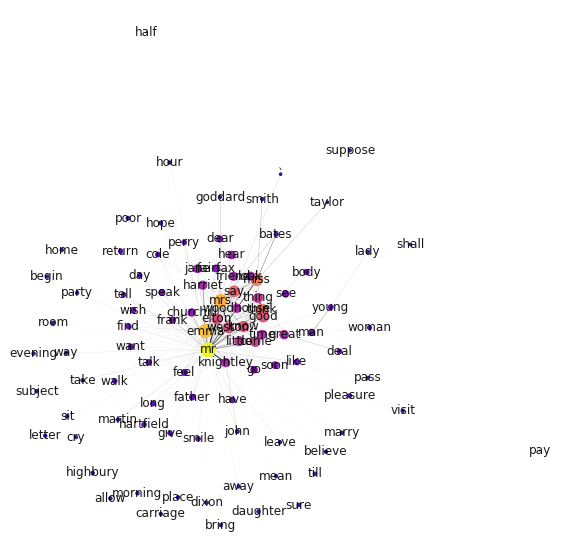

In [57]:
#Plot it using eigenvector centrality
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_emma.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_emma.edges(data = True)))
nx.draw(giant_emma, ax = ax, pos = layout, labels = {n:n for n in giant_emma.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_emma.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant_emma.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant_emma.nodes],
        cmap = plt.get_cmap('plasma')) 

From the graph above we can see that the words having high eigenvector centrality are approximately concentrated in the words we have seen before. There are quite a few words with similar low eigenvector centrality value here, so we only look at those top words in the following analysis. 

In [58]:
#Top 10 words
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('mr', 0.37403399787142877),
 ('emma', 0.32014644280905064),
 ('mrs', 0.30452940091851904),
 ('miss', 0.25458316176690476),
 ('think', 0.23660713193035554),
 ('say', 0.2157746435207186),
 ('good', 0.1971440418982407),
 ('know', 0.19557265136497087),
 ('elton', 0.19300814891646106),
 ('weston', 0.19240123343760993)]

Nothing has changed...

At last, let us look at global statistics for this network. 

In [59]:
nx.density(giant_emma)

0.06829896907216494

In [60]:
#Average degree per node
np.mean([v for w,v in nx.degree(giant_emma)])

6.556701030927835

In [61]:
#The average distance between two nodes in this network
nx.diameter(giant_emma)

4

### A little summary for exercise 2
From the analysis above we can see that the novel is mainly about our main character Emma and her relationship between different men in the society. The novel is mostly carried out by dialogue and character's thoughts. 
As for global statistics in this novel, we can see that the average distance between any two nodes in this network is quite close, which implies that this novel itself is centralized (not having much complicated plots and settings), and its language is also quite simple. 

In [62]:
emma_df

,chapter,text,tokenized_sents,normalized_sents
0,0,[Emma by Jane Austen 1816] VOLUME I,"[[Emma, by, Jane, Austen, 1816, VOLUME, I]]","[[emma, jane, austen, volume]]"
1,1,"Emma Woodhouse, handsome, clever, and rich, ...","[[Emma, Woodhouse, handsome, clever, and, rich...","[[emma, woodhouse, handsome, clever, rich, com..."
2,2,"Mr. Weston was a native of Highbury, and bor...","[[Mr., Weston, was, a, native, of, Highbury, a...","[[mr, weston, native, highbury, bear, respecta..."
3,3,Mr. Woodhouse was fond of society in his own...,"[[Mr., Woodhouse, was, fond, of, society, in, ...","[[mr, woodhouse, fond, society, way], [like, f..."
4,4,Harriet Smith's intimacy at Hartfield was so...,"[[Harriet, Smith, 's, intimacy, at, Hartfield,...","[[harriet, smith, intimacy, hartfield, soon, s..."
5,5,"""I do not know what your opinion may be, Mrs...","[[I, do, not, know, what, your, opinion, may, ...","[[know, opinion, mrs, weston, say, mr, knightl..."
6,6,Emma could not feel a doubt of having given ...,"[[Emma, could, not, feel, a, doubt, of, having...","[[emma, feel, doubt, have, give, harriet, fanc..."
7,7,The very day of Mr. Elton's going to London ...,"[[The, very, day, of, Mr., Elton, 's, going, t...","[[day, mr, elton, go, london, produce, fresh, ..."
8,8,Harriet slept at Hartfield that night. For ...,"[[Harriet, slept, at, Hartfield, that, night],...","[[harriet, sleep, hartfield, night], [week, pa..."
9,9,"Mr. Knightley might quarrel with her, but Em...","[[Mr., Knightley, might, quarrel, with, her, b...","[[mr, knightley, quarrel, emma, quarrel], [dis..."


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

First I shall look at the noun-verbs pair relationship in the novel "Emma".

In [63]:
import spacy
nlp = spacy.load('en')

def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [71]:
gNV = posCooccurrence(emma_df['normalized_sents'].sum(), 'NN', 'VB')

In [72]:
#Basic information about this graph
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2733
Number of edges: 46788
Average degree:  34.2393


In [73]:
#Remove those coocurrance between verbs and verbs
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [74]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2733
Number of edges: 14242
Average degree:  10.4222


In [78]:
#Drop low weight edges and low degree vertices
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 5])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [79]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 32
Average degree:   4.9231


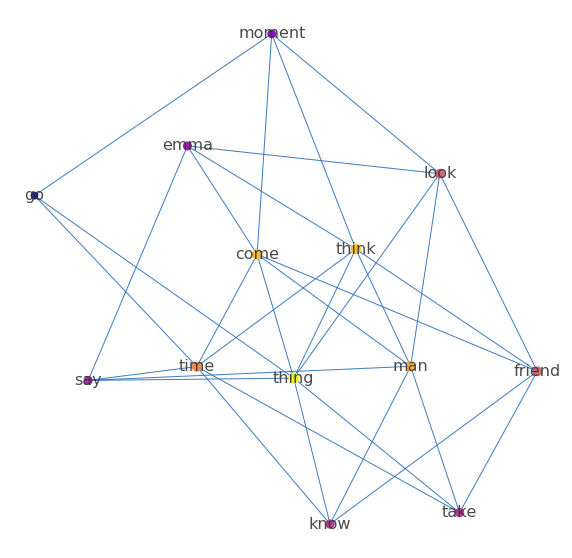

In [80]:
#Plot this graph
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Wow... We can see from this graph that the novel is mainly about emma and her movements, such as "emma come", "emma think", "emma say", and "emma look". Insterestingly, the graph illustrates that there are only three kinds of characters in this novel, "emma", our main character, "man", her target, and her friends. 

Now let us create a subgraph of man. What kind of things that man are insterested in at 18th century?

In [81]:
g_i = gNV.subgraph(['man'] + list(gNV.neighbors('man')))
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 6
Average degree:   1.7143


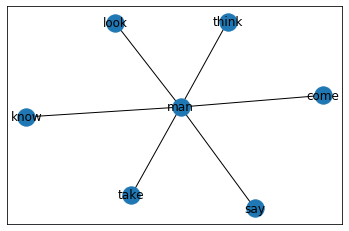

In [82]:
nx.draw_networkx(g_i)

Ah. Nothing interesting here. 

In [83]:
#Now let us look at words that are two-step away from man
manNeighbors = set(gNV.neighbors('man'))
manNeighborsPlus1 = set(manNeighbors)
for n in manNeighbors:
    manNeighborsPlus1 |= set(gNV.neighbors(n))

gNV_man = gNV.subgraph(manNeighborsPlus1)
print(nx.info(gNV_man))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 29
Average degree:   4.8333


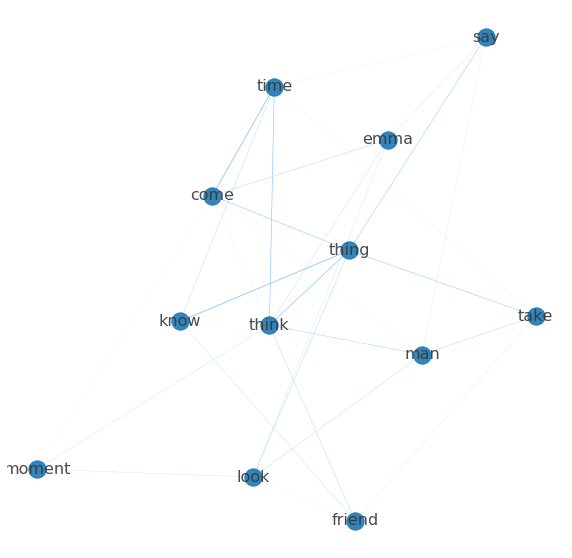

In [84]:
layout_emma = nx.spring_layout(gNV_man, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_emma = nx.eigenvector_centrality(gNV_man)
maxC = max(centralities_emma.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_man.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_man.edges(data = True)))
nx.draw(gNV_man, ax = ax, pos = layout_emma, labels = {n:n for n in gNV_man.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_man.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [85]:
#What about words that are 3 steps away from man
manNeighborsPlus2 = set(manNeighborsPlus1)
for n in manNeighborsPlus1:
    manNeighborsPlus2 |= set(gNV.neighbors(n))

gNV_man2 = gNV.subgraph(manNeighborsPlus2)
print(nx.info(gNV_man2))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 32
Average degree:   4.9231


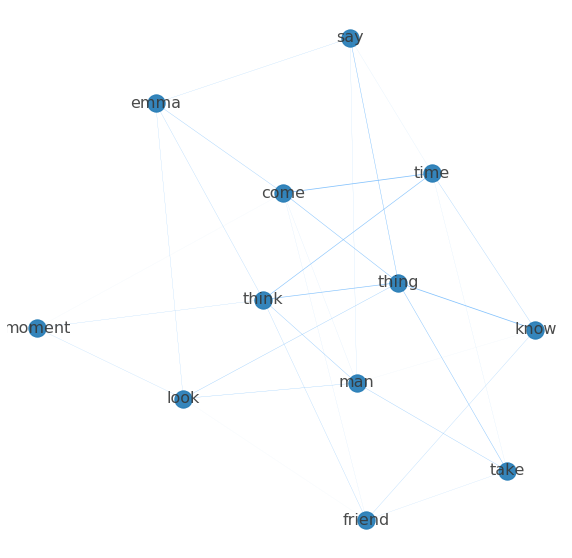

In [86]:
layout_emma = nx.spring_layout(gNV_man, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_emma = nx.eigenvector_centrality(gNV_man)
maxC = max(centralities_emma.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_man.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_man.edges(data = True)))
nx.draw(gNV_man, ax = ax, pos = layout_emma, labels = {n:n for n in gNV_man.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNV_man.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

Secondly, I shall look at the adjective-noun relationship in this network.

In [87]:
gJN = posCooccurrence(emma_df['normalized_sents'].sum(), 'JJ', 'NN')

In [88]:
#Basic information about this graph
print(nx.info(gJN))

Name: 
Type: Graph
Number of nodes: 3592
Number of edges: 67638
Average degree:  37.6604


In [89]:
#Remove those coocurrance between same kind of words
gJN.remove_edges_from([(n1,n2) for n1,n2,d in gJN.edges(data = True) if gJN.nodes[n1]['bipartite'] == gJN.nodes[n2]['bipartite']])

In [90]:
print(nx.info(gJN))

Name: 
Type: Graph
Number of nodes: 3592
Number of edges: 28953
Average degree:  16.1208


In [91]:
#Drop low weight edges and low degree vertices
gJN.remove_edges_from([(n1, n2) for n1, n2, d in gJN.edges(data = True) if d['weight'] <= 3])
gJN.remove_nodes_from([n for n in gJN.nodes if len(set(gJN.neighbors(n))) <= 5])

print(nx.info(gJN))

Name: 
Type: Graph
Number of nodes: 53
Number of edges: 222
Average degree:   8.3774


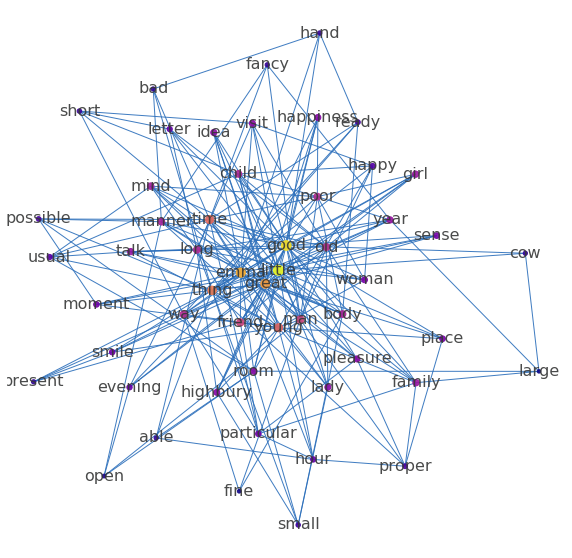

In [92]:
#Plot this graph
layout_nn = nx.spring_layout(gJN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_jn = nx.eigenvector_centrality(gJN)
maxC = max(centralities_jn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gJN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gJN.edges(data = True)))
nx.draw(gJN, ax = ax, pos = layout_nn, labels = {n: n for n in gJN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_jn[n] / maxC for n in gJN.nodes],
        node_size = [centralities_jn[n] / maxC * 100 for n in gJN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

From this graph we can see that the most adjectives used here are positive, such as "great", "good", and "young". Other related nouns are quite casual and old-fashioned such as "room", "body", "child", and "manner". These words are exactly those things that considered by single ladies at that time when they evaluate potential husbands. 

Now let us focus on the subgraph of man, as before. 

In [93]:
g_i = gJN.subgraph(['man'] + list(gJN.neighbors('man')))
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 12
Average degree:   1.8462


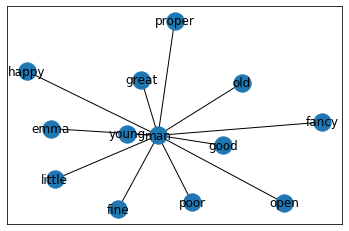

In [94]:
nx.draw_networkx(g_i)

Man are mostly evaluated by their wealth (poor) age (young & old), appearance (fine, fancy, and fine). Quite a cruel and utilitarian world. 

In [96]:
#Now let us look at words that are two-step away from man
manNeighbors = set(gJN.neighbors('man'))
manNeighborsPlus1 = set(manNeighbors)
for n in manNeighbors:
    manNeighborsPlus1 |= set(gJN.neighbors(n))

gJN_man = gJN.subgraph(manNeighborsPlus1)
print(nx.info(gJN_man))

Name: 
Type: Graph
Number of nodes: 42
Number of edges: 161
Average degree:   7.6667


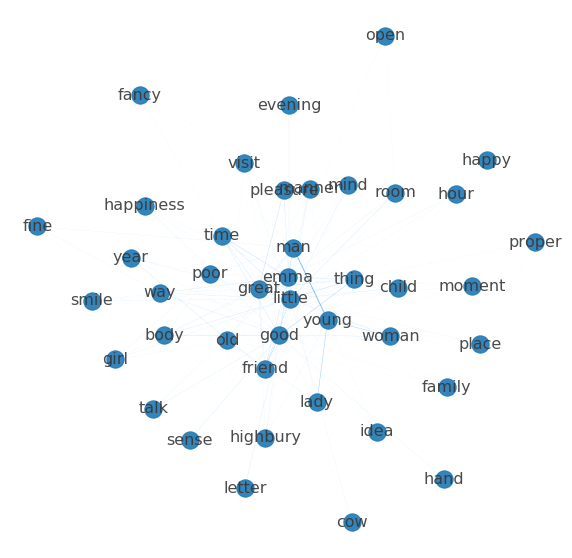

In [97]:
layout_emma = nx.spring_layout(gJN_man, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_emma = nx.eigenvector_centrality(gJN_man)
maxC = max(centralities_emma.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gJN_man.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gJN_man.edges(data = True)))
nx.draw(gJN_man, ax = ax, pos = layout_emma, labels = {n:n for n in gJN_man.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gJN_man.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [98]:
#What about words that are 3 steps away from man
manNeighborsPlus2 = set(manNeighborsPlus1)
for n in manNeighborsPlus1:
    manNeighborsPlus2 |= set(gJN.neighbors(n))

gJN_man2 = gJN.subgraph(manNeighborsPlus2)
print(nx.info(gJN_man2))

Name: 
Type: Graph
Number of nodes: 53
Number of edges: 222
Average degree:   8.3774


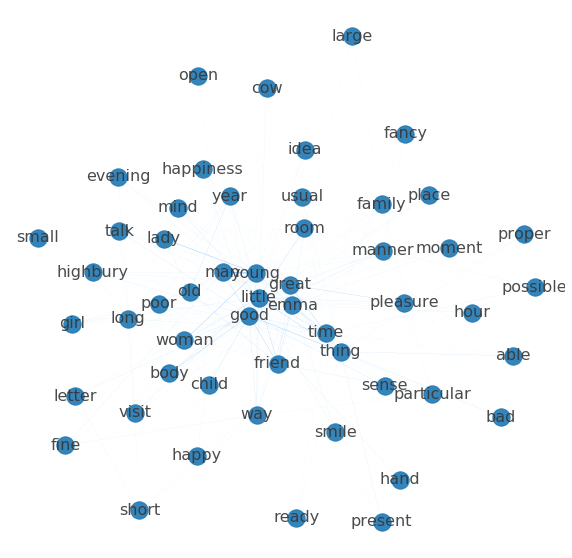

In [99]:
layout_emma = nx.spring_layout(gJN_man2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_emma = nx.eigenvector_centrality(gJN_man2)
maxC = max(centralities_emma.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gJN_man2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gJN_man2.edges(data = True)))
nx.draw(gJN_man2, ax = ax, pos = layout_emma, labels = {n:n for n in gJN_man2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gJN_man2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

The patterns reveal in the two graphs above show the things that often surrounds man in Jane Austen's novel. And those words surrounding it also demonstrate some typical symbols that often appear in Jane Austen's genres, such as "letter", "momemt", "present", "evening", and "happiness". 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In this exercise, I will use soap opera corpora just as the example, choosing another soap opera: Young and Restless. 

In [101]:
#First, load the corpora texts
corpora_address = "../week-5/SOAP"
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [102]:
import zipfile

zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)
            
import pandas as pd

soap_dict = {}

for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [103]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])
i = 0

In [104]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [105]:
#Extract Young and Restless from the main dataframe
yar = soap_df['Tokenized Texts'][9]

In [106]:
#Now investigate how many characters exists in this opera
characters = {}

for token in yar:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [107]:
len(characters)

875

In [108]:
#Now extract the main characters
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Nikki 3720
Victoria 3365
Billy 2246
Paul 2022
Michael 3568
Brad 2177
Ashley 2988
Victor 4981
Sharon 3733
Jill 2487
Jack 4739
Neil 2907
Phyllis 4736
J.T. 2170
Lauren 2220
Nick 4048
Kay 2205
Lily 3233
Sighs 2879
Kevin 2507
Daniel 2380


In [110]:
#Here present the basic graph for characters in this opera.
actor_network = nx.Graph()

for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

actor_network.nodes.data()

NodeDataView({'Nikki': {'lines_spoken': 3720, 'words': []}, 'Victoria': {'lines_spoken': 3365, 'words': []}, 'Billy': {'lines_spoken': 2246, 'words': []}, 'Paul': {'lines_spoken': 2022, 'words': []}, 'Michael': {'lines_spoken': 3568, 'words': []}, 'Brad': {'lines_spoken': 2177, 'words': []}, 'Ashley': {'lines_spoken': 2988, 'words': []}, 'Victor': {'lines_spoken': 4981, 'words': []}, 'Sharon': {'lines_spoken': 3733, 'words': []}, 'Jill': {'lines_spoken': 2487, 'words': []}, 'Jack': {'lines_spoken': 4739, 'words': []}, 'Neil': {'lines_spoken': 2907, 'words': []}, 'Phyllis': {'lines_spoken': 4736, 'words': []}, 'J.T.': {'lines_spoken': 2170, 'words': []}, 'Lauren': {'lines_spoken': 2220, 'words': []}, 'Nick': {'lines_spoken': 4048, 'words': []}, 'Kay': {'lines_spoken': 2205, 'words': []}, 'Lily': {'lines_spoken': 3233, 'words': []}, 'Sighs': {'lines_spoken': 2879, 'words': []}, 'Kevin': {'lines_spoken': 2507, 'words': []}, 'Daniel': {'lines_spoken': 2380, 'words': []}})

In [111]:
#Create the graph
i = 0

for token in yar:
    i += 1
    if i > len(yar):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in yar[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(yar[i:j])

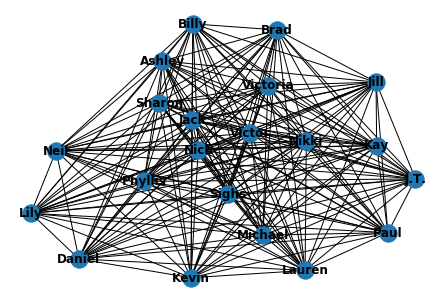

In [112]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

The relationship between different characters in this opera is very messy, just as we expected. 

In [113]:
#And if there are any structure between these people...
smaller_actor_network = nx.Graph()

for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])

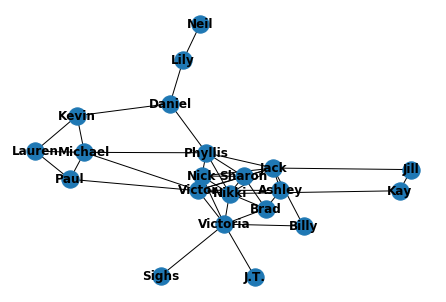

In [114]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

Ah, unlike Days of our lives, the characters in Young and Restless do not seem to have strong cliques. However, there are some people who remains in the outside of our main character cluster. Such as Lily, she only have large conversation with Daniel, and Neil only have direct connection with Lily. 

In [115]:
actor_love_network = nx.Graph()

for character in characters:
    if characters[character] > 2000:
        actor_love_network.add_node(character, lines_spoken= characters[character], words=[])

actor_love_network.nodes.data()

NodeDataView({'Nikki': {'lines_spoken': 3720, 'words': []}, 'Victoria': {'lines_spoken': 3365, 'words': []}, 'Billy': {'lines_spoken': 2246, 'words': []}, 'Paul': {'lines_spoken': 2022, 'words': []}, 'Michael': {'lines_spoken': 3568, 'words': []}, 'Brad': {'lines_spoken': 2177, 'words': []}, 'Ashley': {'lines_spoken': 2988, 'words': []}, 'Victor': {'lines_spoken': 4981, 'words': []}, 'Sharon': {'lines_spoken': 3733, 'words': []}, 'Jill': {'lines_spoken': 2487, 'words': []}, 'Jack': {'lines_spoken': 4739, 'words': []}, 'Neil': {'lines_spoken': 2907, 'words': []}, 'Phyllis': {'lines_spoken': 4736, 'words': []}, 'J.T.': {'lines_spoken': 2170, 'words': []}, 'Lauren': {'lines_spoken': 2220, 'words': []}, 'Nick': {'lines_spoken': 4048, 'words': []}, 'Kay': {'lines_spoken': 2205, 'words': []}, 'Lily': {'lines_spoken': 3233, 'words': []}, 'Sighs': {'lines_spoken': 2879, 'words': []}, 'Kevin': {'lines_spoken': 2507, 'words': []}, 'Daniel': {'lines_spoken': 2380, 'words': []}})

In [120]:
#Now try to create a "love" structure of these characters. 
#If the conversation between two characters contain "love", then add a weight between these two nodes.
i = 0
token_love = False

for token in yar:
    i += 1
    if i > len(yar):
        break
    if token[0] == "@":
        if token[2:] in actor_love_network.nodes():
            j = i
            for token_ in yar[i:]:
                if token_ == "love":
                    token_love = True
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_love_network.nodes() and token_love == True:
                        if (token[2:], token_[2:]) not in actor_love_network.edges():
                            actor_love_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_love_network.edges():
                            actor_love_network.edges[(token[2:], token_[2:])]['weight'] += 1
                        token_love = False
                    break
                j += 1
            # adding characters sentences
            actor_love_network.nodes[token[2:]]['words'].append(yar[i:j])

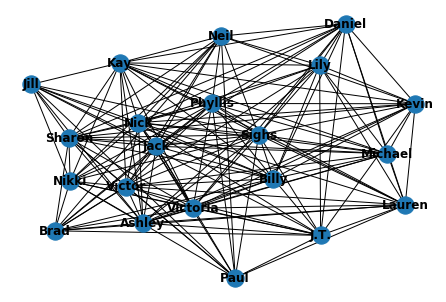

In [121]:
nx.draw(actor_love_network, with_labels=True, font_weight='bold')

Ah...Seems like they really love each other. Let's see if we can make this graph smaller.

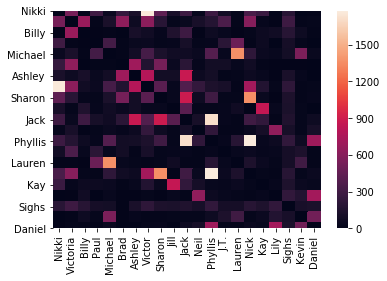

In [122]:
import seaborn as sns

L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [123]:
smaller_actor_love_network = nx.Graph()

In [156]:
#Only keep those characters who speaks the word "love" to each other more than 3000 times.
#It seems that they really love each other in this sense...
for actor_1 in actor_love_network.nodes():
    smaller_actor_love_network.add_node(actor_1, lines_spoken= actor_love_network.nodes[actor_1]['lines_spoken'], words=actor_love_network.nodes[actor_1]['words'])
    for actor_2 in actor_love_network.nodes():
        if (actor_1, actor_2) in actor_love_network.edges() and actor_2!=actor_1:
            if actor_love_network.edges[(actor_1, actor_2)]['weight'] > 3000:
                smaller_actor_love_network.add_edge(actor_1, actor_2, weight=actor_love_network.edges[(actor_1, actor_2)]['weight'])


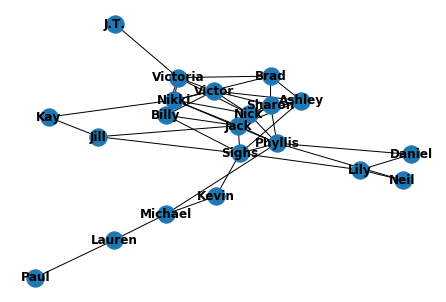

In [157]:
nx.draw(smaller_actor_love_network, with_labels=True, font_weight='bold')

Now we can see who is the most dedicated person in this opera. Paul only loves Lauren, Lauren only loves Michael... A sad story.